In [2]:
%load_ext cython

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
import multiprocessing as mp
import random
from multiprocessing import Pool
import os
from tqdm import tqdm
print("Number of processors: ", mp.cpu_count())
n_process= mp.cpu_count()

Number of processors:  48


In [4]:
%%cython -a --cplus --compile-args=-std=c++11 -I</home/ddsukhoverkhova/.conda/envs/mc_lib_env/lib/python3.9/site-packages/mc_lib>
cimport cython
import numpy as np
cimport numpy as np

from libc.math cimport exp, tanh
from mc_lib.rndm cimport RndmWrapper
from mc_lib.lattices import tabulate_neighbors
from mc_lib.observable cimport RealObservable
    
cdef void init_spins(long[::1] spins, RndmWrapper rndm): 
    
    for j in range(spins.shape[0]):
        spins[j] = 1 if rndm.uniform() > 0.5 else -1
        
        
        
@cython.boundscheck(False)
@cython.wraparound(False)
cdef double energy(long[::1] spins, 
                   long[:, ::1] neighbors,
                  const double[:,::1] Js):

    cdef:
        double ene = 0.0
        Py_ssize_t site, site1, num_neighb

    for site in range(spins.shape[0]):
        num_neighb = neighbors[site, 0]
        for j in range(1, num_neighb+1):
            site1 = neighbors[site, j]
            ene += -1 * Js[site, site1] * spins[site] * spins[site1] 
    
    return ene / 2.0



@cython.boundscheck(False)
@cython.wraparound(False)
cdef void flip_spin(long[::1] spins, 
                    const long[:, ::1] neighbors,
                    double beta,
                    const double[:,::1] Js, RndmWrapper rndm): 
    cdef:
        Py_ssize_t site = int(spins.shape[0] * rndm.uniform())
        Py_ssize_t site1

    cdef long num_neighb = neighbors[site, 0]
    cdef double summ = 0.
    for j in range(1, num_neighb + 1):
        site1 = neighbors[site, j]
        summ += spins[site1] * spins[site] * Js[site,site1]
   
    cdef double ratio = exp(-2.0 * beta * summ )
    
    if rndm.uniform() > ratio:
        return

    spins[site] = -spins[site]
    
    
cdef void get_J( double[:,::1] Js, double J, double Jd, int L1, int L2):
    
    for i in range(L1*L2):
        Js[i, ((i // L2 + 1) % L1 * L2 )  + (i + 1) % L2 ] = Jd
        Js[i, ((i // L2  - 1) % L1 * L2 )  + (i - 1) % L2 ] = Jd
        Js[i, (i // L2) * L2 + (i + 1) % L2] = J 
        Js[i, (i + L2) % (L1*L2)] = J
        Js[i, (i // L2) * L2 + (i - 1) % L2] = J
        Js[i, (i - L2) % (L1*L2)] = J
    return
        

def simulate(Py_ssize_t L,
             double T, double J, double Jd,
             Py_ssize_t num_sweeps, int seed, int rseed = 1234):

    cdef:
        long[:, ::1] neighbors = tabulate_neighbors(L, kind='triang') 
        double beta = 1./T

    cdef:
        
        int num_therm = int(30 * L)
        int steps_per_sweep = L * L 
        int sweep = 0
        int i
        double Z = 0., magn = 0., binder = 0., error = 0.
        
    
    cdef RndmWrapper rndm = RndmWrapper((rseed, seed)) 
    cdef RealObservable m2 = RealObservable()
    cdef RealObservable m4 = RealObservable()

    cdef long[::1] spins =  np.empty( L*L, dtype=int) 
    init_spins(spins, rndm)
    
    cdef double[:,::1] Js = np.zeros((L*L, L*L)) 
    get_J(Js, J, Jd, L, L)

    for sweep in range(num_therm):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)

    m = np.zeros(num_sweeps)

    for sweep in range(num_sweeps):
        for i in range(steps_per_sweep):
            flip_spin(spins, neighbors, beta, Js, rndm)
            
        Z += 1
        magn = 0.
        for i in range(L*L):
            magn += spins[i]
            
        m2.add_measurement(magn**2)
        m4.add_measurement(magn**4)
        m[sweep] = magn
        
    binder = 1 - (m4.mean) / (3 * (m2.mean**2))
    
    error = np.sqrt( ( m4.errorbar/( 3*(m2.mean**2)) )**2 + ( 2*(m4.mean)*m2.errorbar/(3*(m2.mean**3) ) )**2 )
     
    return (binder, error, m)
  

In [14]:
def cums(data):
    
    # функция для паралелльного запуска
    
    Temps = data[0]
    Jd = data[1]
    T = len(Temps)
    
    sim_len = int(2e6)

    b_120 = np.zeros(T)
    e_120 = np.zeros(T)
    b_20 = np.zeros(T)
    e_20 = np.zeros(T)
    b_40 = np.zeros(T)
    e_40 = np.zeros(T)
    b_80 = np.zeros(T)
    e_80 = np.zeros(T)
    b_100 = np.zeros(T)
    e_100 = np.zeros(T)
    b_4 = np.zeros(T)
    e_4 = np.zeros(T)
    
    seed = os.getpid() 
    
    for j in tqdm(range(len(Temps))):
        #b_120[j], e_120[j], m  = simulate(120,t,1,Jd,int(2e6), seed, j)
        #np.save(f'data_binders/data_{Jd:.1f}/magn_{20}_{t:.3f}_{Jd:.1f}_{seed}.npy', m) 
        
        #b_4[j], e_4[j], m  = simulate(4,Temps[j],1,Jd,sim_len, seed, j)
        #np.save(f'data_binders/data_{Jd:.1f}/magn_{4}_{t:.3f}_{Jd:.1f}_{seed}.npy', m) 
        
        #b_20[j], e_20[j], m  = simulate(20,Temps[j],1,Jd,sim_len, seed, j)
        
        b_40[j], e_40[j], m  = simulate(40,Temps[j],1,Jd,sim_len, seed, j)
        #np.save(f'data_binders/data_{Jd:.1f}/magn_{40}_{t:.3f}_{Jd:.1f}_{seed}.npy', m) 
        
        #b_80[j], e_80[j], m  = simulate(80,t,1,Jd,sim_len, seed, j)
        #np.save(f'data_binders/data_{Jd:.1f}/magn_{80}_{t:.3f}_{Jd:.1f}_{seed}.npy', m)
        
        #b_100[j], e_100[j], m  = simulate(100,t,1,Jd,sim_len, seed, j)
        #np.save(f'data_binders/data_{Jd:.1f}/magn_{100}_{t:.3f}_{Jd:.1f}_{seed}.npy', m)
        
    #return  ((b_40), (e_40), (b_80), (e_80), (b_100), (e_100), (b_120), (e_120)) #((b_120, b_20, b_40, b_80), (e_120, e_20, e_40, e_80))
    #return  b_4, e_4
    return  b_40, e_40

In [37]:
with open('data_binders/res_0.0.npy', 'rb') as f:
    data = np.load(f)

In [10]:
roots = [2.2691853142129728, 2.104982167992544, 1.932307699120554, 1.749339162933206, 1.5536238493280832, 1.34187327905057, 1.109960313758399, 0.8541630993606272, 0.5762735442012712, 0.2885386111960936, 0.03198372863548067]
jds = [0.0, -0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1.0]
get_crit_T = dict(zip(jds,roots))

In [6]:
len(roots)

11

In [7]:
round(get_crit_T[-0.7],3)

0.854

In [15]:
%%time
Jd = 0.0
T_crit = round(get_crit_T[Jd],3)

#Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 20)
Temps = np.linspace(0.5, 3.0, 25)
N = 48

T = len(Temps)
#data = list(zip([Temps]*N, [Jd]*N))
data = list(zip([Temps], [Jd]))

pool = Pool(N)

res = pool.map(cums, data) 
res = np.asarray(res) 
# массив (N,2,4,T), где 2 - это пара (средн., ошибка), 4 - количество размеров L  

pool.close()
np.save(f'data_binders/res_{Jd:.1f}_40.npy', res)

100%|██████████| 25/25 [1:23:05<00:00, 199.41s/it]


CPU times: user 82.3 ms, sys: 201 ms, total: 284 ms
Wall time: 1h 23min 5s


In [16]:
%%time
Jd = -0.1
T_crit = round(get_crit_T[Jd],3)

#Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 20)
Temps = np.linspace(0.5, 3.0, 25)
N = 48

T = len(Temps)
#data = list(zip([Temps]*N, [Jd]*N))
data = list(zip([Temps], [Jd]))

pool = Pool(N)

res = pool.map(cums, data) 
res = np.asarray(res) 
# массив (N,2,4,T), где 2 - это пара (средн., ошибка), 4 - количество размеров L  

pool.close()
np.save(f'data_binders/res_{Jd:.1f}_40.npy', res)

100%|██████████| 25/25 [1:47:27<00:00, 257.88s/it]


CPU times: user 101 ms, sys: 210 ms, total: 311 ms
Wall time: 1h 47min 27s


In [17]:
%%time
Jd = -0.5
T_crit = round(get_crit_T[Jd],3)

#Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 20)
Temps = np.linspace(0.5, 3.0, 25)
N = 48

T = len(Temps)
#data = list(zip([Temps]*N, [Jd]*N))
data = list(zip([Temps], [Jd]))

pool = Pool(N)

res = pool.map(cums, data) 
res = np.asarray(res) 
# массив (N,2,4,T), где 2 - это пара (средн., ошибка), 4 - количество размеров L  

pool.close()
np.save(f'data_binders/res_{Jd:.1f}_40.npy', res)

100%|██████████| 25/25 [1:24:14<00:00, 202.19s/it]


CPU times: user 72 ms, sys: 224 ms, total: 296 ms
Wall time: 1h 24min 15s


In [12]:
def cums_10(data):
    
    # функция для паралелльного запуска
    
    Temps = data[0]
    Jd = data[1]
    T = len(Temps)
    
    sim_len = int(2e6)

    b_10 = np.zeros(T)
    e_10 = np.zeros(T)
    
    seed = os.getpid() 
    
    for j in tqdm(range(len(Temps))):
        
        b_10[j], e_10[j], m  = simulate(10,Temps[j],1,Jd,sim_len, seed, j)
        
    return  b_10, e_10

In [13]:
%%time
Jd = 0.0
T_crit = round(get_crit_T[Jd],3)

#Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 20)
Temps = np.linspace(0.5, 3.0, 25)
N = 48

T = len(Temps)
data = list(zip([Temps], [Jd]))

pool = Pool(N)

res = pool.map(cums_10, data) 
res = np.asarray(res) 
# массив (N,2,4,T), где 2 - это пара (средн., ошибка), 4 - количество размеров L  

pool.close()
np.save(f'data_binders/res_{Jd:.1f}_10.npy', res)

100%|██████████| 25/25 [04:57<00:00, 11.91s/it]


CPU times: user 33.8 ms, sys: 145 ms, total: 178 ms
Wall time: 4min 57s


In [14]:
%%time
Jd = -0.1
T_crit = round(get_crit_T[Jd],3)

#Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 20)
Temps = np.linspace(0.5, 3.0, 25)
N = 48

T = len(Temps)
data = list(zip([Temps], [Jd]))

pool = Pool(N)

res = pool.map(cums_10, data) 
res = np.asarray(res) 
# массив (N,2,4,T), где 2 - это пара (средн., ошибка), 4 - количество размеров L  

pool.close()
np.save(f'data_binders/res_{Jd:.1f}_10.npy', res)

100%|██████████| 25/25 [06:01<00:00, 14.46s/it]


CPU times: user 31.6 ms, sys: 145 ms, total: 176 ms
Wall time: 6min 1s


In [15]:
%%time
Jd = -0.5
T_crit = round(get_crit_T[Jd],3)

#Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 20)
Temps = np.linspace(0.5, 3.0, 25)
N = 48

T = len(Temps)
data = list(zip([Temps], [Jd]))

pool = Pool(N)

res = pool.map(cums_10, data) 
res = np.asarray(res) 
# массив (N,2,4,T), где 2 - это пара (средн., ошибка), 4 - количество размеров L  

pool.close()
np.save(f'data_binders/res_{Jd:.1f}_10.npy', res)

100%|██████████| 25/25 [05:03<00:00, 12.12s/it]


CPU times: user 22.4 ms, sys: 164 ms, total: 186 ms
Wall time: 5min 3s


In [7]:
Temps = np.linspace(0.5, 3.0, 25)

In [16]:
with open('data_binders/res_-0.5_10.npy', 'rb') as f:
    data0 = np.load(f)

with open('data_binders/res_-0.5_20.npy', 'rb') as f:
    data1 = np.load(f)
    
with open('data_binders/res_-0.5_40.npy', 'rb') as f:
    data2 = np.load(f)
    
with open('data_binders/res_-0.5_80.npy', 'rb') as f:
    data3 = np.load(f)

In [11]:
data.shape

(48, 2, 25)

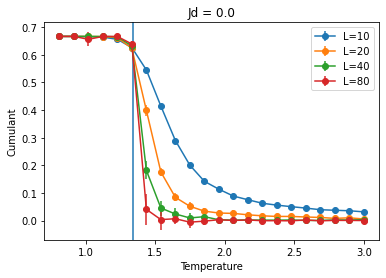

In [17]:
#Jd = -0.5

plt.errorbar(Temps[3:], data0[-1, 0, 3:], data0[-1, 1, 3:], label = "L=10", fmt='o-')
plt.errorbar(Temps[3:], data1[-1, 0, 3:], data1[-1, 1, 3:], label = "L=20", fmt='o-')
plt.errorbar(Temps[3:], data2[-1, 0, 3:], data2[-1, 1, 3:], label = "L=40", fmt='o-')
plt.errorbar(Temps[3:], data3[-1, 0, 3:], data3[-1, 1, 3:], label = "L=80", fmt='o-')
#plt.errorbar(T, binder_10[0, :], err_10[0, :], label = "L=10")#, fmt='o-')
#plt.errorbar(T, binder_20[0, :], err_20[0, :], label = "L=20")#, fmt='o-')
#plt.errorbar(T, binder_40[0, :], err_40[0, :], label = "L=40", fmt='o-')
#plt.plot(T, binders[0, 4, :], label = "L=80")
plt.xlabel('Temperature')
plt.ylabel('Cumulant')
plt.axvline(x=round(get_crit_T[-0.5],3))
plt.title("Jd = 0.0")
plt.legend()
plt.show();

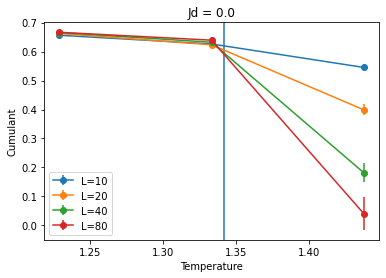

In [18]:
#Jd = -0.5

plt.errorbar(Temps[7:10], data0[-1, 0, 7:10], data0[-1, 1, 7:10], label = "L=10", fmt='o-')
plt.errorbar(Temps[7:10], data1[-1, 0, 7:10], data1[-1, 1, 7:10], label = "L=20", fmt='o-')
plt.errorbar(Temps[7:10], data2[-1, 0, 7:10], data2[-1, 1, 7:10], label = "L=40", fmt='o-')
plt.errorbar(Temps[7:10], data3[-1, 0, 7:10], data3[-1, 1, 7:10], label = "L=80", fmt='o-')
#plt.errorbar(T, binder_10[0, :], err_10[0, :], label = "L=10")#, fmt='o-')
#plt.errorbar(T, binder_20[0, :], err_20[0, :], label = "L=20")#, fmt='o-')
#plt.errorbar(T, binder_40[0, :], err_40[0, :], label = "L=40", fmt='o-')
#plt.plot(T, binders[0, 4, :], label = "L=80")
plt.xlabel('Temperature')
plt.ylabel('Cumulant')
plt.axvline(x=round(get_crit_T[-0.5],3))
plt.title("Jd = 0.0")
plt.legend()
plt.show();

In [ ]:
Jd = -0.3
T_crit = round(get_crit_T[Jd],3)
N = 100
Temps = np.linspace(T_crit - 0.01, T_crit + 0.01, 8)
T = len(Temps)

b_20 = np.zeros((N,T))

for i in tqdm(range(N)):
    for j,t in enumerate(Temps):
        b_20[i,j]  = simulate(20,t,1,Jd,int(2e6), 1234, i)

 56%|█████▌    | 56/100 [4:52:45<3:49:21, 312.76s/it]

In [ ]:
np.save('b_20.npy', b_20)